In [14]:
import pandas as pd
import numpy 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle


In [4]:
# load sample data
home_stat = pd.read_csv("/Users/paraspokharel/Programming/pitchProphet/pitchProphet/data/pre_processing/processed/home_stats_43rows.csv")
away_stat = pd.read_csv("/Users/paraspokharel/Programming/pitchProphet/pitchProphet/data/pre_processing/processed/away_stats_43rows.csv")
match_stat = pd.read_csv("/Users/paraspokharel/Programming/pitchProphet/pitchProphet/data/pre_processing/processed/match_info_with_labels_43rows.csv")


In [5]:
# prepare training data


if "Unnamed: 0" in home_stat.columns: 
    home_stat.drop(columns = ["Unnamed: 0"], inplace = True)
if "Unnamed: 0" in away_stat.columns: 
    away_stat.drop(columns = ["Unnamed: 0"], inplace = True)

# rename columns
home_stat.columns = ["h" + col for col in home_stat.columns]
away_stat.columns = ["a" + col for col in away_stat.columns]
x_df = pd.concat([home_stat, away_stat], axis = 1)
y_df = match_stat[["label"]]

x_df = x_df.apply(pd.to_numeric)
y_df = y_df.apply(pd.to_numeric)

x_train, x_test = train_test_split(x_df, test_size = 0.3, random_state = 42)
y_train, y_test = train_test_split(y_df, test_size = 0.3, random_state = 42)

print(x_train,y_train)

    hGls_mean  hGls_std    hGls_trend  hAst_mean  hAst_std    hAst_trend  \
19   0.666667  0.577350 -5.000000e-01   0.333333  0.577350 -5.000000e-01   
17   1.750000  0.957427 -1.000000e-01   1.500000  0.577350 -2.967196e-16   
13   1.000000  0.816497  4.000000e-01   1.000000  0.816497  4.000000e-01   
40   1.000000  0.816497  2.000000e-01   0.250000  0.500000  1.000000e-01   
15   3.250000  1.258306  3.000000e-01   2.500000  0.577350  4.000000e-01   
9    1.333333  1.527525  5.000000e-01   1.000000  1.000000  5.000000e-01   
16   1.750000  1.500000  3.000000e-01   1.500000  1.290994 -2.967196e-16   
30   0.666667  0.577350  5.000000e-01   0.000000  0.000000 -0.000000e+00   
26   0.666667  0.577350  5.000000e-01   0.333333  0.577350  5.000000e-01   
0    1.500000  0.707107  1.000000e+00   1.500000  0.707107  1.000000e+00   
29   0.333333  0.577350 -5.000000e-01   0.000000  0.000000 -0.000000e+00   
41   2.250000  0.957427  3.000000e-01   1.750000  0.500000  3.000000e-01   
5    1.00000

In [6]:
# Train boost with softprob to get probabilities
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3, learning_rate=0.1, max_depth=6, n_estimators=100)

# Fit the model with early stopping and evaluation metric
model.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_test, y_test)],    
          verbose=False) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

In [8]:
# evaluate
eval_result = model.evals_result()

# get predictions
y_pred = model.predict(x_test)  
y_pred_proba = model.predict_proba(x_test)  

# convert y_test DataFrame object to numpy array and flatten
y_test_np = y_test.values.ravel()

# calculate ROC AUC score for multiclass
try:
    # one-vs-Rest ROC AUC
    auc_ovr = roc_auc_score(y_test_np, y_pred_proba, multi_class='ovr', average='macro')
    print(f"One-vs-Rest ROC AUC: {auc_ovr:.3f}")
    
    # calculate accuracy
    accuracy = (y_pred == y_test_np).mean()
    print(f"Accuracy: {accuracy:.3f}")
    
except Exception as e:
    print(f"Error calculating ROC AUC: {str(e)}")

One-vs-Rest ROC AUC: 0.400
Accuracy: 0.538


In [22]:
# download model (pickle converts to byte stream)
pickle.dump(model, open(r"../xgb_model.pkl", "wb"))

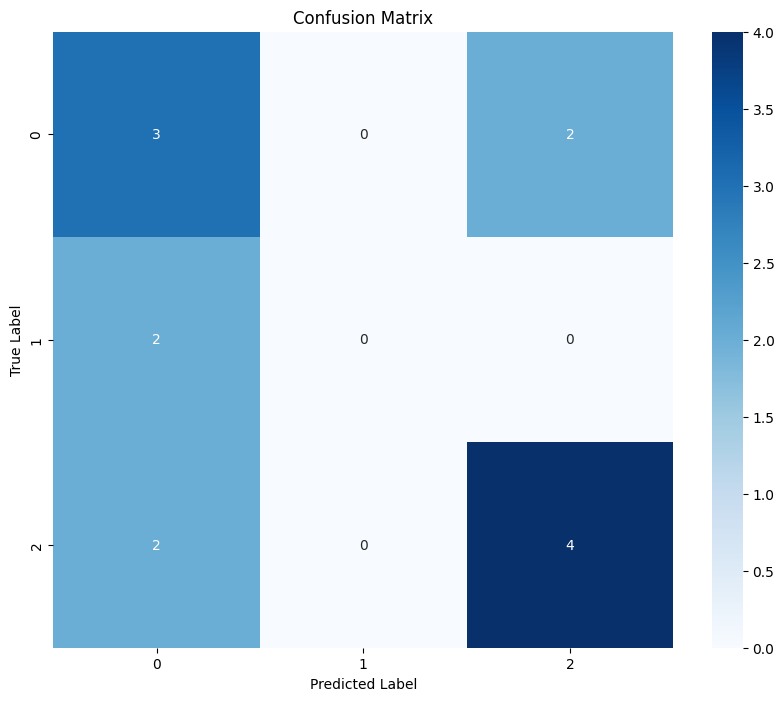

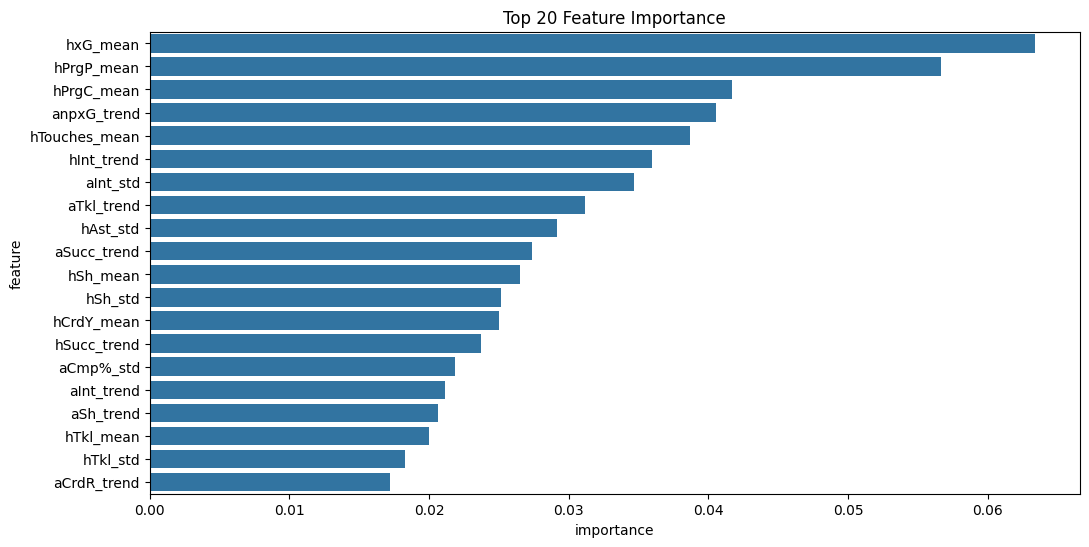


Classification Report:
              precision    recall  f1-score   support

    Home Win       0.43      0.60      0.50         5
        Draw       0.00      0.00      0.00         2
    Away Win       0.67      0.67      0.67         6

    accuracy                           0.54        13
   macro avg       0.37      0.42      0.39        13
weighted avg       0.47      0.54      0.50        13



/Users/paraspokharel/Library/Caches/pypoetry/virtualenvs/pitchprophet-7T2v2vkn-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paraspokharel/Library/Caches/pypoetry/virtualenvs/pitchprophet-7T2v2vkn-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/paraspokharel/Library/Caches/pypoetry/virtualenvs/pitchprophet-7T2v2vkn-py3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being s

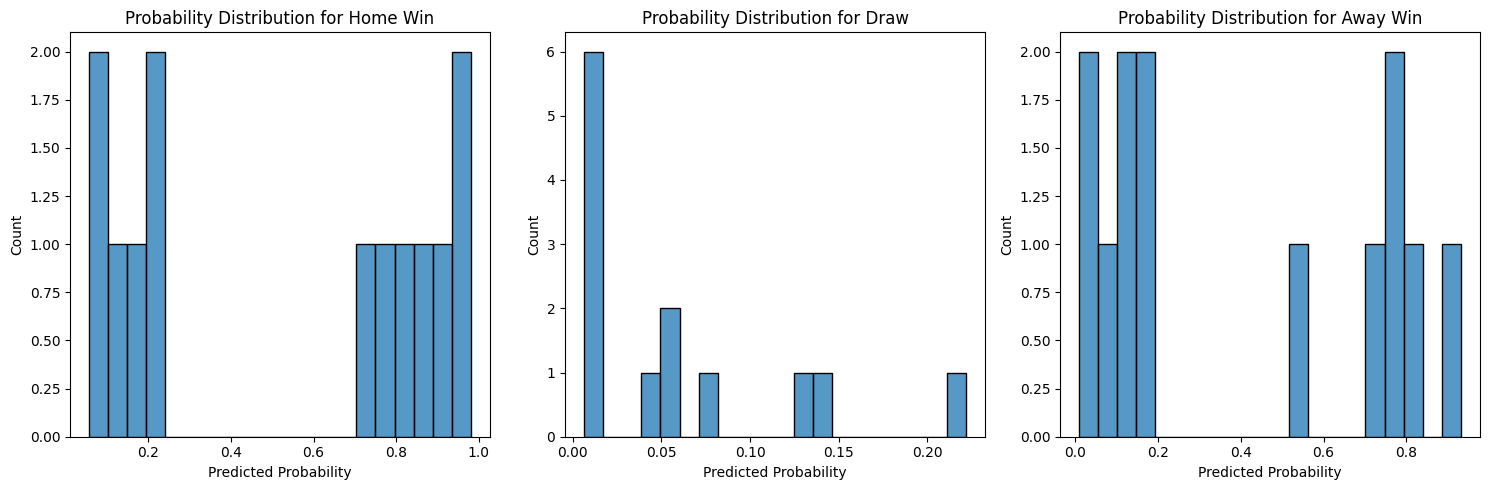

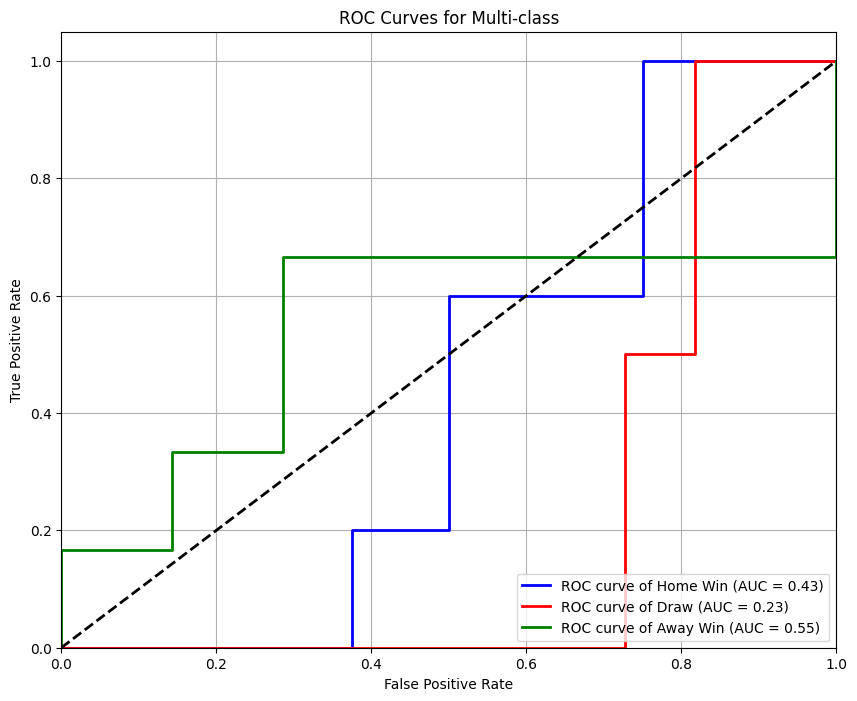

In [16]:
# Plots

# confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_np, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# feature importance
plt.figure(figsize=(12, 6))
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)[:20]  # Top 20 features
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Feature Importance')
plt.show()

# report
print("\nClassification Report:")
print(classification_report(y_test_np, y_pred, target_names=['Home Win', 'Draw', 'Away Win']))

# probablity distributoin
plt.figure(figsize=(15, 5))
for i, label in enumerate(['Home Win', 'Draw', 'Away Win']):
    plt.subplot(1, 3, i+1)
    sns.histplot(y_pred_proba[:, i], bins=20)
    plt.title(f'Probability Distribution for {label}')
    plt.xlabel('Predicted Probability')
plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(10, 8))
n_classes = 3
fpr = {}
tpr = {}
roc_auc = {}
classes = ['Home Win', 'Draw', 'Away Win']

# calculate ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot ROC curves
colors = ['blue', 'red', 'green']
for i, color in enumerate(colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {classes[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()